In [1]:
import json
import cv2
import PIL.Image as Image
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

In [2]:
image_root = '/opt/ml/COW/original_data/image/val'
label_root = '/opt/ml/COW/original_data/label/val'

label_dict = {j: os.path.join(label_root, j) for j in os.listdir(label_root) if os.path.isdir(os.path.join(label_root, j) )}
print(label_dict)
json_file_dict = {}
for each_label, each_location in label_dict.items():
    json_file_dict[each_label] = [os.path.join(each_location, i) for i in os.listdir(each_location) if '.json' in i]

for each_label, each_json in json_file_dict.items():
    print(f'{each_label}: {each_json[:5]}')

{'two': '/opt/ml/COW/original_data/label/val/two', 'one': '/opt/ml/COW/original_data/label/val/one', 'three': '/opt/ml/COW/original_data/label/val/three', 'onep': '/opt/ml/COW/original_data/label/val/onep', 'onepp': '/opt/ml/COW/original_data/label/val/onepp'}
two: ['/opt/ml/COW/original_data/label/val/two/QC_cow_segmentation_2_070694.json', '/opt/ml/COW/original_data/label/val/two/QC_cow_segmentation_2_074232.json', '/opt/ml/COW/original_data/label/val/two/QC_cow_segmentation_2_072409.json', '/opt/ml/COW/original_data/label/val/two/QC_cow_segmentation_2_077318.json', '/opt/ml/COW/original_data/label/val/two/QC_cow_segmentation_2_070354.json']
one: ['/opt/ml/COW/original_data/label/val/one/QC_cow_segmentation_1_075759.json', '/opt/ml/COW/original_data/label/val/one/QC_cow_segmentation_1_074381.json', '/opt/ml/COW/original_data/label/val/one/QC_cow_segmentation_1_071385.json', '/opt/ml/COW/original_data/label/val/one/QC_cow_segmentation_1_075108.json', '/opt/ml/COW/original_data/label/v

In [3]:
json_dict = {}
for each_label, jsons in json_file_dict.items():
    json_dict[each_label]= []
    for each_position in jsons:
        with open(os.path.join(each_position),'r', encoding='utf8') as f:
            contents = f.read()
            json_data = json.loads(contents)
        json_dict[each_label].append(json_data['label_info'])   
for each_label in json_dict:
    print(each_label)
    print(json_dict[each_label][0]) 

two
{'image': {'file_name': 'QC_cow_segmentation_2_070694.jpg', 'width': 1080, 'height': 1920}, 'shapes': [{'label': 'hanwoo', 'points': [[257.2659001228988, 1224.4198074630287], [248.95383778219565, 1257.6680568258414], [283.86449961314895, 1267.6425316346854], [325.42481131666483, 1279.2794189116698], [318.7751614441023, 1320.8397306151855], [347.0361734024931, 1352.4255675098577], [383.6092477015871, 1374.036929595686], [403.5581973192747, 1410.61000389478], [461.7426337041969, 1440.5334283213112], [504.96535787585344, 1458.8199654708583], [569.7994441333382, 1442.195840789452], [636.2959428589636, 1420.5844787036237], [689.493141839464, 1392.323466745233], [742.6903408199643, 1362.4000423187015], [747.6775782243861, 1320.8397306151855], [746.0151657562456, 1274.2921815072477], [812.511664481871, 1227.7446323993101], [799.2123647367458, 1174.5474334188098], [797.5499522686052, 1129.6622967790126], [857.396801121668, 1088.1019850754967], [897.2947003570432, 1029.9175486905744], [908.

In [4]:
def segment_polygon(json_list, label, filter=None, factor = 0):
    polygon_list = []
    factor = factor + 1
    for i in tqdm(json_list[label]) :
        pt = i['shapes'][0]['points']
        lft = int(min(pt)[0])
        rig = int(max(pt)[0])
        tp = int(max(pt,key=lambda x:x[1])[1])
        bot = int(min(pt,key=lambda x:x[1])[1])
        width = i['image']['width']
        height = i['image']['height']
        polygon = np.array(pt,dtype=np.int32)
        empty_array = np.zeros((height,width,3),np.uint8)
        polygon = cv2.fillPoly(empty_array,[polygon],(255,255,255))
        image = cv2.imread(os.path.join(image_root, label, i['image']['file_name']))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if filter == 'bright':
            image = cv2.add(image,np.full(image.shape,(100*factor,100*factor,100*factor),dtype=np.uint8))
        if filter == 'red':
            image = cv2.add(image,np.full(image.shape,(100*factor,70/factor,70/factor),dtype=np.uint8))
        polygon2 = cv2.bitwise_and(image,polygon)
        polygon2 = polygon2[bot:tp,lft:rig,:].copy()
        polygon = polygon[bot:tp,lft:rig,:].copy()
        polygon_list.append([polygon2,polygon])
    return polygon_list

In [5]:
#Generate Segmented Images Dictionary
polygon_dict = {}
for each_label in json_dict:
    #print( len(json_dict[each_label]))
    polygon_dict[each_label] = segment_polygon(json_dict, each_label) #[:3000] 
    #print( len(polygon_dict[each_label]) )

100%|██████████| 2478/2478 [01:49<00:00, 22.63it/s]


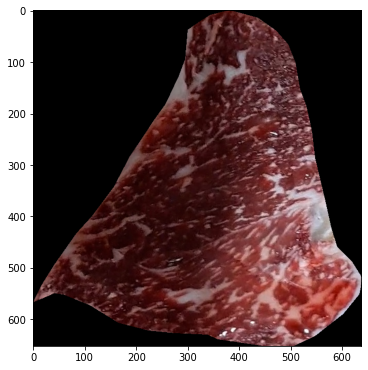

In [6]:
#visualize an example image
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(polygon_dict['one'][0][0])

In [7]:
#Generate Segmented Image Files (path: image_destination_root)  

#image_write_train_root = '/opt/ml/COW/Mod/image/train/' 
destination_root = '/opt/ml/COW/Mod2'
_image_destination_root = os.path.join(destination_root, 'image') 
image_destination_val_root = os.path.join(_image_destination_root, 'val') 
image_destination_root = image_destination_val_root

if not os.path.isdir(destination_root):
    os.mkdir(destination_root)
if not os.path.isdir(_image_destination_root) :
    os.mkdir(_image_destination_root)    
if not os.path.isdir(image_destination_val_root) :
    os.mkdir(image_destination_root)

print(polygon_dict.keys())
for each_label, each_polygon_list in polygon_dict.items():
    if not os.path.isdir(os.path.join(image_destination_root, each_label)) :
        os.mkdir(os.path.join(image_destination_root, each_label))
    print(each_label)
    for index, each_polygon in  enumerate(each_polygon_list):
        if len(each_polygon[0]) != 0 and len(each_polygon[0][0]) != 0:
            cv2.imwrite( os.path.join(image_destination_root, each_label, str(index) + '.jpg')  , cv2.cvtColor(each_polygon[0], cv2.COLOR_RGB2BGR))            

dict_keys(['two', 'one', 'three', 'onep', 'onepp'])
two
one
three
onep
onepp


In [8]:
#mix two images (optional)
def image_conv(bg,fg):
    bgw,bgh = bg.shape[:2]
    fgw,fgh = fg[0].shape[:2]
    bgw = int((bgw-fgw)/2)
    bgh = int((bgh-fgh)/2)
    roi = bg[bgw:bgw+fgw,bgh:bgh+fgh,:]
    mask = cv2.bitwise_not(fg[1])
    roi = cv2.bitwise_and(roi,mask)
    roi = cv2.add(roi,fg[0])
    bg[bgw:bgw+fgw,bgh:bgh+fgh,:] = roi
    return bg

In [9]:
image = cv2.imread('white_wall.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(1024,1024))